# Homework 3: Logistic Regression Optimization
## Ender Erkaya
### November 12, 2021

In [1]:
import math;
import matplotlib.pyplot as plt
import scipy.io as scio
import scipy.stats as stats
import scipy.linalg as linalg
import numpy as np
import pandas as pd

# safe logarithm function 
# avoid log(0) -> numerical problems
def safelog(x):
    return(np.log(x + 1e-100))

In [2]:
## Import Data
data_set = scio.loadmat('Question2Data.mat')
Y = np.transpose(np.array(data_set['y']))
b = np.transpose((data_set['b'])).astype(int)
m = Y.shape[0]
D = Y.shape[1]

## a)

### The Gradient

$$ S(\alpha_k) = \frac{1}{1+e^{-(\alpha_k)}}= \frac{1}{1+e^{-(b_k \boldsymbol{x}^T \boldsymbol{y_k})}} $$ as sigmoid function

$$ f(\boldsymbol{x}) = f_1(\boldsymbol{x}) + f_2(\boldsymbol{x})$$ as cost function where
$$ f_1(\boldsymbol{x}) = \sum\limits_{k=1}^{m} -log(S(\alpha_k)) $$ logistic cost 
$$ f_2(\boldsymbol{x}) = \lambda ||\boldsymbol{x}||_2^2 $$ regularization cost
\
The gradient of the cost function is given below:
\begin{align*}
\nabla{f_1(x)} &= -\sum\limits_{k = 1}^{m} \frac{(\nabla S(\alpha_k))} {S(\alpha_k)} = -\sum\limits_{k = 1}^{m} -b_k * \boldsymbol{y_k} * {S(\alpha_k)} * (1-{S(\alpha_k)}) * \frac{1}{{S(\alpha_k)}} = \sum\limits_{k = 1}^{m} (1-{S(\alpha_k)}) b_k \boldsymbol{y_k} \\
\nabla{f_2(x)} &= 2 \lambda \boldsymbol{x} \\
\nabla{f(x)} &=  \sum\limits_{k = 1}^{m} (1-{S(\alpha_k)}) b_k \boldsymbol{y_k} + 2 \lambda \boldsymbol{x}
\end{align*}

### The Hessian

The Hessian matrix for the cost function is given below:
\begin{align*}
\nabla^{2}{f_1(x)} &= \sum\limits_{k = 1}^{m} b_k \boldsymbol{y_k} \nabla^T (1-{S(\alpha_k)}) \\
                   &= \sum\limits_{k = 1}^{m} b_k \boldsymbol{y_k} (-S(\alpha_k)(1-S(\alpha_k))) -b_k y_k^T \\
                   &= \sum\limits_{k = 1}^{m} b_k^2 S(\alpha_k)(1-S(\alpha_k)) y_k y_k^T \\
\nabla^{2}{f_2(x)} &= 2 \lambda \boldsymbol{I} \\
\nabla^{2}{f(x)} &= \sum\limits_{k = 1}^{m} b_k^2 S(\alpha_k)(1-S(\alpha_k)) y_k y_k^T + 2 \lambda \boldsymbol{I}
\end{align*}

## b) Strong Convexity

$\nabla^2(f_1(x))$ is a conic combination of m rank-1 symmetric matrices of $y_k y_k^T$ since $b_k^2 S(\alpha_k)(1-S(\alpha_k)) \geq 0$ due to $0 \geq S(\alpha) \leq 1$. Hence, it is a positive semi-definite matrix of $rank \leq min(D=2,m)$. To demonstrate:
$$ h^T (\sum\limits_{k = 1}^{m} b_k^2 S(\alpha_k)(1-S(\alpha_k)) y_k y_k^T) h = \sum\limits_{k = 1}^{m} h^T (b_k^2 S(\alpha_k)(1-S(\alpha_k)) y_k y_k^T) h =\sum\limits_{k = 1}^{m} b_k^2 S(\alpha_k)(1-S(\alpha_k)) (h^T y_k)^2 \geq 0 $$
Thus it has eigenvalues $\lambda_{{f_1}_{(1,2)}} \geq 0$. The eigenvales of $f(x)$, $\lambda_{f_{\{1,2\}}} \geq 2*\lambda$.
With a choise of regularization parameter $\lambda > 0$ guarantees strong convexity due  to that $\lambda_{f_{min}} \geq 2 \lambda > 0$. Chosen $\lambda = 8$, the cost function is a strongly convex function.

## c) Gradient Update Rule

$$ x^{(t+1)} = x^{(t)} - \mu \nabla{f(x)} = x^{(t)} - \mu ((\sum\limits_{k = 1}^{m} (1-{S(\alpha_k)}) b_k \boldsymbol{y_k}) + 2 \lambda \boldsymbol{x^{(t)} }) = x^{(t)} + \mu ((\sum\limits_{k = 1}^{m} \frac{e^{-(b_k \boldsymbol{x}^T \boldsymbol{y_k})}}{1+e^{-(b_k \boldsymbol{x}^T \boldsymbol{y_k}}} b_k y_k) - 2 \lambda \boldsymbol{x^{(t)} } )$$

## d) Gradient Descent

In [3]:
# define the sigmoid function
def sigmoid(a):
    return(1 / (1 + np.exp(-a)))

# define the objective function
def objective_function(Y, b, x):
    return(np.sum(-safelog(sigmoid(b * np.matmul(Y, x)))) + lambd * np.linalg.norm(x,2)**2)

In [4]:
# Settings
lambd    = 8
mu       = 0.01
num_iter = 100 
x_init   = np.random.uniform(low = -0.01, high = 0.01, size = (D, 1))
x        = x_init
x_grad   = x
objective_gradient = objective_function(Y, b, x)

# Gradient Update Iterations
for i in range(num_iter):
    alpha = b * np.matmul(Y, x)
    temp1 = (1-sigmoid(alpha)) * b
    temp2 = np.matmul(np.transpose(temp1),Y)
    grad  = 2 * lambd * x - np.transpose(temp2)
    x     = x - mu * grad
    objective_gradient = np.append(objective_gradient,objective_function(Y, b, x))
    x_grad = np.hstack((x_grad, x))


### e) Newton Algorithm

In [5]:
# Newton Settings
num_iter = 100
x        = x_init
x_newton = x
objective_newton = objective_function(Y, b, x)
# Backtracking settings
backtracking_on = 1
gamma    = 1e-4
alph     = 0.5
max_back = 20

# Newton Update Iterations
for i in range(num_iter):
    alpha = b * np.matmul(Y, x)
    # calculate the gradient
    temp1 = (1-sigmoid(alpha)) * b
    temp2 = np.matmul(np.transpose(temp1),Y)
    grad  = 2 * lambd * x - np.transpose(temp2)
    # calculate the hessian
    H1    = np.matmul(np.transpose(np.reshape(b,(np.size(b),1))**2 * sigmoid(alpha) * (1-sigmoid(alpha)) * Y), Y)
    H     = H1 + 2 * lambd * np.identity(D)
    newton_step = -np.matmul(linalg.cho_solve(linalg.cho_factor(H), np.eye(D)), grad) # inverse cholesky
    
    # Backtracking line search
    t = 1
    back_iter = 0
    while backtracking_on:
        back_iter = back_iter + 1;
        x_prev = x 
        x = x + t * newton_step;
        if back_iter > max_back:
            break
        if (objective_function(Y, b, x) - objective_function(Y, b, x_prev)) < (gamma * t * np.matmul(np.transpose(grad), newton_step)):
            break
        t = t * alph
        
    x_newton = np.hstack((x_newton, x))
    objective_newton = np.append(objective_newton, objective_function(Y, b, x))

objective_final = objective_newton[num_iter]

## f) Nesterov Iteration

In [6]:
# Nesterov Settings
num_iter = 100
x        = x_init
x_nesterov = x
y_nesterov = x
objective_nesterov = objective_function(Y, b, x)
beta     = 0
# Nesterov Update Iterations
for i in range(num_iter):
    alpha = b * np.matmul(Y, x)
    # calculate the gradient
    temp1 = (1-sigmoid(alpha)) * b
    temp2 = np.matmul(np.transpose(temp1),Y)
    grad  = 2 * lambd * x - np.transpose(temp2)
    
    #beta_prev = beta 
    #beta      = (1 + math.sqrt(1 + 4 * beta**2))/2
    #beta_next = (1 + math.sqrt(1 + 4 * beta**2))/2
    #gama      = (1-beta)/beta_next
    
    H1    = np.matmul(np.transpose((b**2) * sigmoid(alpha) * (1-sigmoid(alpha)) * (Y)), Y)
    H     = H1 + 2 * lambd * np.identity(D)
    L     = np.amax(np.linalg.eigvals(H))
    kappa    = np.linalg.cond(H)
    gama     = (1 - math.sqrt(kappa))/(1 + math.sqrt(kappa))
    
    y_nesterov_prev = y_nesterov
    y_nesterov      = x - (1/L) * grad
    
    x      = (1 - gama) * y_nesterov + gama * y_nesterov_prev;
    
    x_nesterov = np.hstack((x_nesterov, x))
    objective_nesterov = np.append(objective_nesterov, objective_function(Y, b, x))
                 

## g) Convergence Path Visualization

In [7]:
# evaluate discriminant function on a grid
num_grid    = 261
y1_interval = np.linspace(-0.1, +1.2, num_grid)
y2_interval = np.linspace(-0.1, +1.2, num_grid)
[y1_grid, y2_grid]  = np.meshgrid(y1_interval, y2_interval)
cost_function       = np.zeros((num_grid,num_grid))
for i in range(num_grid-1):
    for j in range(num_grid-1):
        cost_function[i,j] = objective_function(Y, b, [[y1_grid[i,j]], [y2_grid[i,j]]]) 

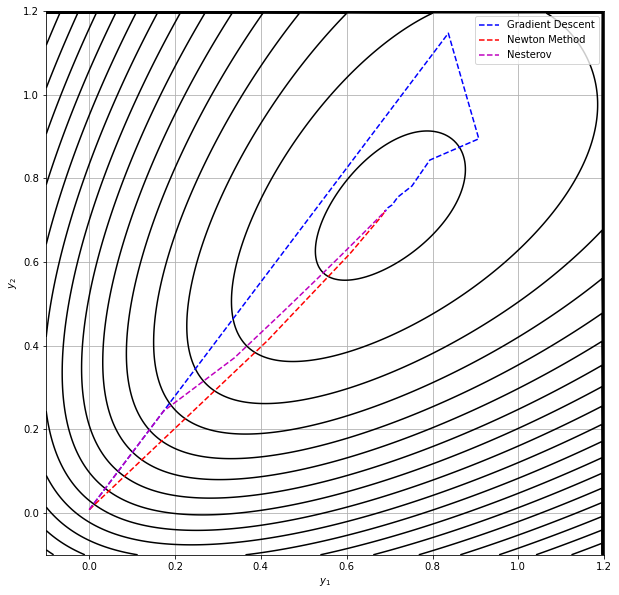

In [8]:
# plot convergence paths
plt.figure(figsize = (10,10))
plt.contour(y1_grid, y2_grid, cost_function, 20, colors = "k")
plt.plot(x_grad[0,:],x_grad[1,:],"b--")
plt.plot(x_newton[0,:],x_newton[1,:],"r--")
plt.plot(x_nesterov[0,:],x_nesterov[1,:],"m--")
plt.grid()
plt.legend(["Gradient Descent","Newton Method","Nesterov"])
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.show()

## h) Objective Function Convergence Plot

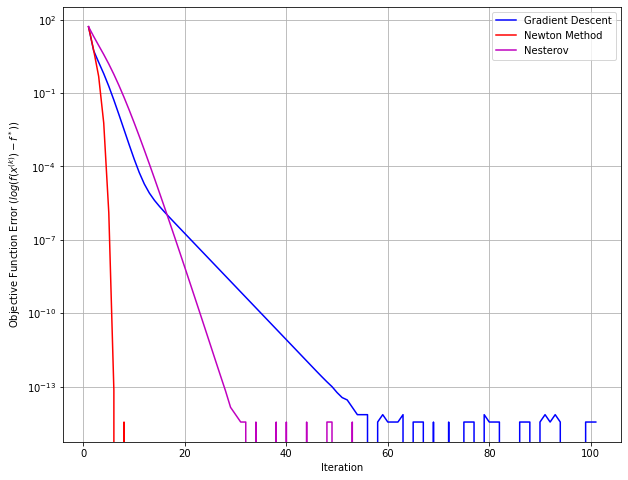

In [9]:
# plot objective function convergence during iterations
plt.figure(figsize = (10, 8))
plt.yscale("log")
plt.plot(range(1, num_iter+2), objective_gradient - objective_final, "b-")
plt.plot(range(1, num_iter+2), objective_newton - objective_final, "r-")
plt.plot(range(1, num_iter+2), objective_nesterov - objective_final, "m-")
plt.grid()
plt.legend(["Gradient Descent","Newton Method","Nesterov"])
plt.xlabel("Iteration")
plt.ylabel("Objective Function Error ($log(f(x^{(k)})-f^*)$)")
plt.show()

## i) Visualization

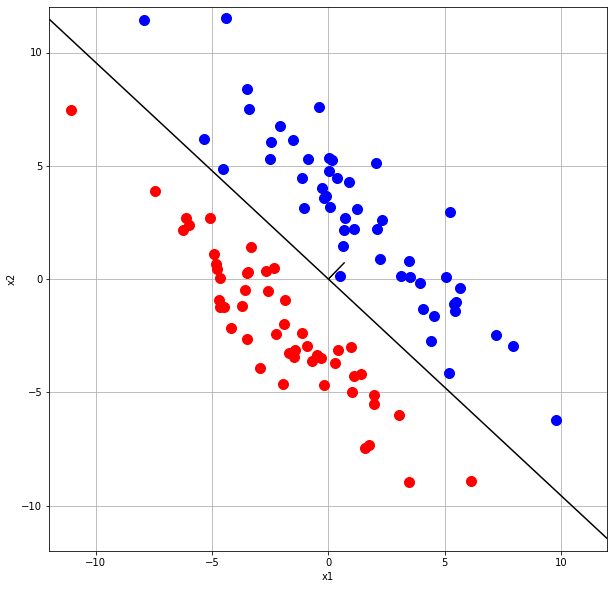

In [10]:
num_grid    = 2401
y1_interval = np.linspace(-12, +12, num_grid)
y2_interval = np.linspace(-12, +12, num_grid)
[y1_grid, y2_grid]  = np.meshgrid(y1_interval, y2_interval)
discriminant_values = x_newton[0,num_iter] * y1_grid + x_newton[1,num_iter] * y2_grid #used for discriminant line evaluation

# discrminant line and data visualized
plt.figure(figsize = (10, 10))
plt.plot(Y[np.ravel(b) == 1, 0], Y[np.ravel(b) == 1, 1], "bo", markersize = 10)
plt.plot(Y[np.ravel(b) == -1, 0], Y[np.ravel(b) == -1, 1], "ro", markersize = 10 )
plt.contour(y1_grid, y2_grid, discriminant_values, levels = 0, colors = "k")
plt.arrow(0, 0, x_newton[0,100], x_newton[1,100])
plt.grid()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()